In [485]:
#!conda install -y -c anaconda pillow
#!conda install -y -c conda-forge ipywidgets

# Ejercicio 1

In [486]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

In [487]:
import warnings
warnings.simplefilter('ignore')

In [488]:
%matplotlib inline
plt.style.use('classic')



In [616]:
def load_image(img):
    imgmat_array = np.array(list(img.getdata()), float)
    imgmat_array = imgmat_array / 255
    imgmat = imgmat_array
    imgmat.shape = (img.size[1], img.size[0] , 3 )
    return (imgmat , imgmat_array)


def load_image_from_disk (image_path):
    img = Image.open(image_path)
    return load_image(img)

def load_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return load_image(img)


def display_image (imgmat):
    plt.figure(figsize=(9, 6))
    #plt.imshow((imgmat * 255).astype(np.uint8))
    plt.imshow(imgmat)
    plt.show()

In [617]:
img_url = "https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/parrots.jpeg"
imgmat , imgmat_array = load_image_from_url(img_url)


# Desde disco local
# imgmat , imgmat_array = load_image_from_disk('images/parrot.jpg')


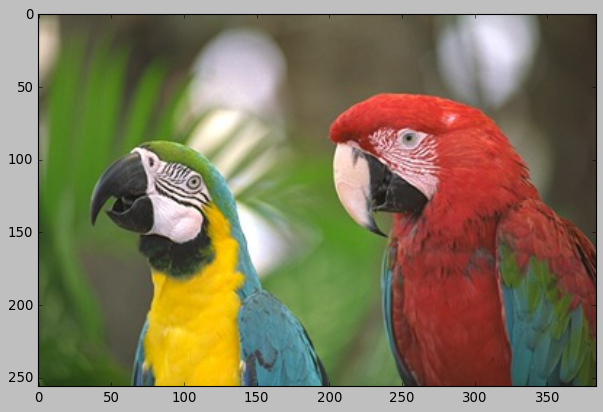

In [618]:
display_image (imgmat)

In [619]:
def generate_yiq_from_rgb(imgmat_array):
    
    yiq_from_rgb_extended = np.array([[0.299,      0.587,        0.114],
                        [0.59590059, -0.27455667, -0.32134392],
                        [0.21153661, -0.52273617, 0.31119955]])
    
    yiq_from_rgb = np.array([[0.299,      0.587,        0.114],
                        [0.595716, -0.274453, -0.321263],
                        [0.211456, -0.522591, 0.311135]])
    
    
    
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def generate_rgb_from_yiq(imgmat_array , alpha , beta):
    yiq_from_rgb = np.array([[1 * alpha, 0.9663 * beta, 0.6210 * beta],
                             [1 * alpha , -0.2721 * beta, -0.6474 * beta],
                             [1 * alpha, -1.1070 * beta, 1.7046* beta] ])
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def iq_strategy_coerce(i,q, beta, i_original, q_original ):

    i_max = 0.5957
    i_min = i_max * -1
    
    q_max = 0.5226
    q_min = q_max * -1

    q_diff = 0
    
    i_coerced = i
    q_coerced = q
    
    if abs(i) > i_max:
        i_coerced = i_min  if i < 0 else i_max
        
    
    if abs(q) > q_max:
        q_coerced = q_min  if i < 0 else q_max

        
    return (i_coerced , q_coerced)

def generate_rgb_from_yiq_control(imgmat_array , alpha , beta , iq_strategy):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            y = alpha * yc[0]
            i = beta * yc[1]
            q = beta * yc[2]
           
            if y > 1:
                y = 1
            
            
            (i,q) = iq_strategy(i,q, beta, yc[1], yc[2])
            
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    result =  np.dot(generated_array, rgb_from_yiq.T.copy())
    
    return result



In [620]:
result = generate_yiq_from_rgb(imgmat_array)

In [621]:
#generate_yiq_from_rgb_control(result)

In [622]:
#result_1 = generate_rgb_from_yiq(result , 1 ,1)

In [623]:
result_1 = generate_rgb_from_yiq_control(result, 1,1, iq_strategy_coerce)
#result_1

In [624]:
imgmat.shape

(256, 384, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


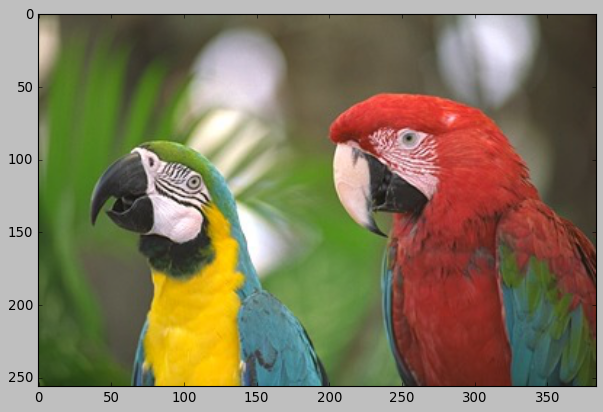

In [625]:
result_1.shape = imgmat.shape
display_image (result_1)

In [626]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
#https://stackoverflow.com/questions/36351109/ipython-notebook-ipywidgets-does-not-show

In [627]:
def modify_image(lumenance, chrome , imgmat_array ,imgmat ):
    
    result = generate_yiq_from_rgb(imgmat_array)
    result_1 = generate_rgb_from_yiq_control(result , lumenance ,chrome , iq_strategy_coerce)
    result_1.shape = imgmat.shape
    display_image (result_1)
    
def modify_image_2(lumenance, chrome):
    modify_image( lumenance /100, chrome / 100 ,imgmat_array = imgmat_array , imgmat  = imgmat)

In [628]:
interact(modify_image_2, lumenance=widgets.IntSlider(min=1, max=200, step=1, value=100) , chrome =widgets.IntSlider(min=1, max=200, step=1, value=100) );

interactive(children=(IntSlider(value=100, description='lumenance', max=200, min=1), IntSlider(value=100, desc…

## Ejercicio 1.2

In [629]:
import math

def generate_rgb_from_yiq_lumenance(imgmat_array , transformation):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            y = transformation(yc[0])
            i = yc[1]
            q = yc[2]
           
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    result =  np.dot(generated_array, rgb_from_yiq.T.copy())
         
    return result


In [630]:
def sqr_transformation(value):
    return math.sqrt(value)

def pow_transformation (value):
    return value * value

def null_transformation(value):
    return value

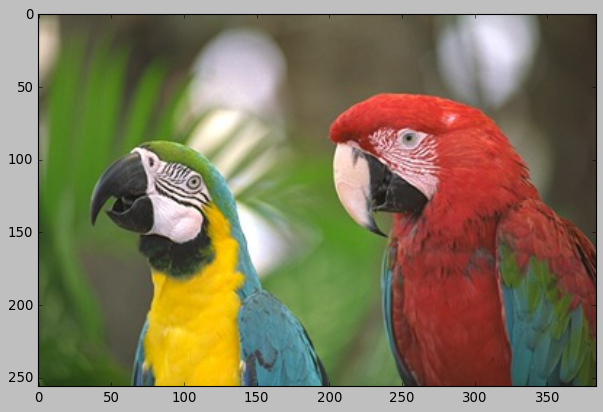

In [631]:
display_image (imgmat)

In [632]:
result = generate_yiq_from_rgb(imgmat_array)
result_1 = generate_rgb_from_yiq_lumenance(result,sqr_transformation )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


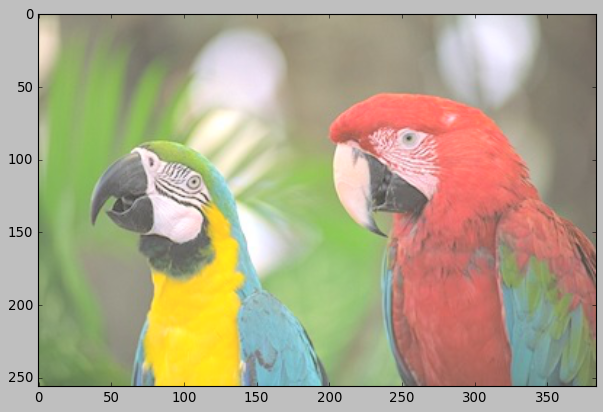

In [633]:
display_image (result_1)

In [534]:
result_1 = generate_rgb_from_yiq_lumenance(result,pow_transformation )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


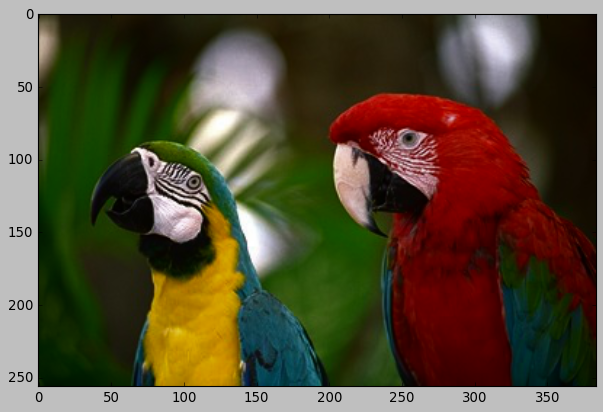

In [535]:
display_image (result_1)

In [540]:
    

    
def modify_image_lumenance_2(strategy):
    
    result = generate_yiq_from_rgb(imgmat_array)
    
    strategy_method = sqr_transformation
    
    
    if strategy == "sqrt":
        strategy_method = sqr_transformation
    elif strategy == "pow":
        strategy_method = pow_transformation
    else: 
        strategy_method = null_transformation
    
    
    result_1 = generate_rgb_from_yiq_lumenance(result,strategy_method )
    result_1.shape = imgmat.shape
    display_image (result_1)

    
drop_down = widgets.Dropdown(
    options=['normal', 'sqrt', 'pow'],
    value='normal',
    description='Filtro:',
    disabled=False,
)    

interact(modify_image_lumenance_2, strategy=drop_down );

interactive(children=(Dropdown(description='Filtro:', options=('normal', 'sqrt', 'pow'), value='normal'), Outp…

In [554]:
def generate_rgb_from_yiq_lumenance_linea_segmentos(imgmat_array , lower_x, upper_x):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
    
    # Referencia
    # m = ( y2 - y1) / (x2 - x1)
    # y - y1 = m (x - x1)
    
    pendiente = 1 / (upper_x - lower_x)
    
   
    
    
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            
            if yc[0] < lower_x:
                y = 0
            elif yc[0] > upper_x:
                y = 1
            else:
                y = (pendiente * ( yc[0] - lower_x))  
            # Referencia y = (pendiente * ( x - lower_x)) 
                
            
            i = yc[1]
            q = yc[2]
           
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    result =  np.dot(generated_array, rgb_from_yiq.T.copy())
         
    return result

In [555]:
result = generate_yiq_from_rgb(imgmat_array)

result_1 = generate_rgb_from_yiq_lumenance_linea_segmentos(result, 0.1 , 0.7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


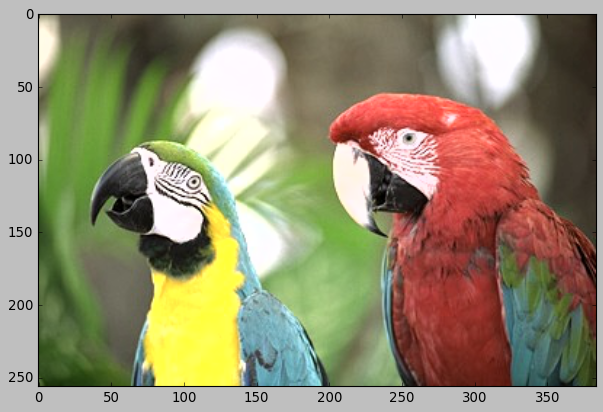

In [556]:
display_image (result_1)

In [557]:
def generate_rgb_from_yiq_lumenance_linea_segmentos_2(low_value, upper_value):
    
    low_value = low_value / 100
    upper_value = upper_value / 100
    result = generate_yiq_from_rgb(imgmat_array)
    result_1 = generate_rgb_from_yiq_lumenance_linea_segmentos(result, low_value, upper_value)
    
    result_1.shape = imgmat.shape
    display_image (result_1)


In [558]:
interact(generate_rgb_from_yiq_lumenance_linea_segmentos_2, low_value=widgets.IntSlider(min=0, max=100, step=1, value=10) , upper_value =widgets.IntSlider(min=0, max=100, step=1, value=80) );

interactive(children=(IntSlider(value=10, description='low_value'), IntSlider(value=80, description='upper_val…

# Ejercicio 1.3

In [592]:

def display_image_cmap_2(map_value):
    display_image_cmap (imgmat[:,:,1] , map_value)
    

def display_image_cmap (imgmat, map_value):
    plt.figure(figsize=(9, 6))
    #plt.imshow((imgmat * 255).astype(np.uint8))
    plt.imshow(imgmat , cmap=map_value)
    plt.show()

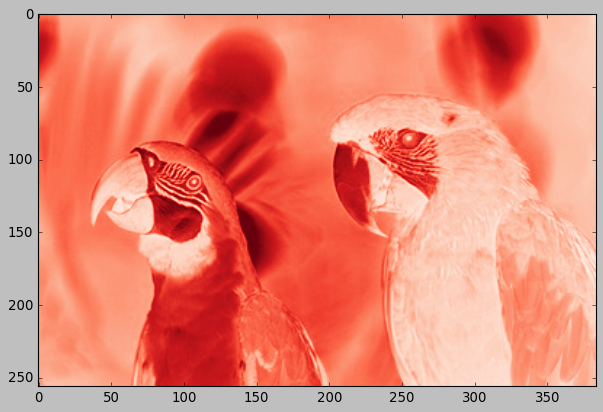

In [593]:
display_image_cmap(imgmat[:,:,1] , "Reds")

In [600]:
#https://predictablynoisy.com/matplotlib/tutorials/colors/colormaps.html
    
mapas_secuencial = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

mapas_secuencial_2 = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']


mapas_divergentes= [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

mapas_misc = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']


drop_down_paleta = widgets.Dropdown(
    options=mapas_secuencial_2,
    value='hot',
    description='Mapa:',
    disabled=False,
)    

interact(display_image_cmap_2, map_value=drop_down_paleta );

interactive(children=(Dropdown(description='Mapa:', index=12, options=('binary', 'gist_yarg', 'gist_gray', 'gr…